In [1]:
import os
from dataset_utils import *

train_path = os.path.join(IMDB_DATA_PATH, "train")
test_path  = os.path.join(IMDB_DATA_PATH, "test")

"""
For details on implementation of dataset loading and other utils check out dataset_utils.py

CONVENTION: label 0 --> negative review
            label 1 --> positive review
"""

#Main training set - Large Movie Review Dataset (IMDB)
((imdb_train_texts, imdb_train_labels), (imdb_test_texts, imdb_test_labels)) = load_imdb_dataset(train_path=train_path, test_path=test_path)

#Review Polarity Datasets
(v1_texts, v1_labels), (v2_texts, v2_labels) = load_polarity(v1_path=POLARITY_v1_DATA_PATH, v2_path=POLARITY_v2_DATA_PATH)

#Rotten tomatoes critic dataset
rotten_train_texts, rotten_train_labels, short_rotten_test, random_rotten_test, pos_rotten_test, neg_rotten_test = load_rotten_split(ROTTEN_PATH, n_train_samples=12000)

In [2]:
from sklearn.model_selection import train_test_split

train_texts_v1, test_texts_v1, train_labels_v1, test_labels_v1 = train_test_split(v1_texts, v1_labels, test_size=0.33, random_state=42)

train_texts = imdb_train_texts + rotten_train_texts + train_texts_v1
train_labels = imdb_train_labels + rotten_train_labels + train_labels_v1

seed=10
random.seed(seed)
random.shuffle(train_texts)
random.seed(seed)
random.shuffle(train_labels)

print(f"Training set size: {len(train_texts)}")

Training set size: 44143


In [38]:
from sklearn.feature_extraction.text import CountVectorizer

MAX_FEATURES = 50000
TARGET_LENGTH = 100

vectorizer = CountVectorizer(ngram_range=(1,1), lowercase=True, max_features=MAX_FEATURES)
vectorizer.fit(train_texts)

vocab = vectorizer.vocabulary_
remapped_vocab = {ngram: idx+1 for idx, (ngram, _) in enumerate(sorted(vocab.items(),key=lambda x: x[1]))}

remapped_vocab['<pad>'] = 0
remapped_vocab['<OOV>'] = len(remapped_vocab)

inverse_vocab = {idx: ngram for ngram, idx in remapped_vocab.items()}

analyzer = vectorizer.build_analyzer()
tokenizer = vectorizer.build_tokenizer()

In [236]:
import torch
from torch import nn
import torch.nn.functional as F

from math import floor

vocab_size = len(remapped_vocab)

class SentimentCNN(nn.Module):
    def __init__(self, embedding_dim, out_channels, kernel_size):
        super().__init__()
        
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.conv = nn.Conv1d(in_channels=embedding_dim, out_channels=out_channels, kernel_size=kernel_size)
        self.conv_stack = nn.Sequential(
            nn.Conv1d(in_channels=embedding_dim, out_channels=out_channels, kernel_size=kernel_size),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.BatchNorm1d(out_channels)
        ) 
    
        self.linear_stack = nn.Sequential(
            nn.Linear(in_features=out_channels, out_features=50),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(in_features=50, out_features=1),
        )
                
    def forward(self, x):
        
        embed = self.embedding(x)
        embed = embed.transpose(1,2)
        
        #conved = F.relu(self.conv(embed))
        conved = self.conv_stack(embed)
    
        #kernel size is the length of sequence out of the conv layer
        pooled = F.max_pool1d(conved, kernel_size=conved.shape[2]).squeeze(2)
        #print(pooled.shape)

        return self.linear_stack(pooled)

In [40]:
def vectorize_text(text, analyzer, vocab):
    analyzed_list = analyzer(text)

    unigrams = [t for t in analyzed_list if len(t.split()) == 1]
    bigrams = [t for t in analyzed_list if len(t.split()) == 2]
    
    bigram_indices = [vocab.get(bigram) for bigram in bigrams]
    unigram_indices = [vocab.get(unigram) for unigram in unigrams]
    
    filled = [0 if idx is None else idx for idx in unigram_indices]
    
    return torch.tensor(filled)


def vectorize_mono(text, tokenizer, vocab):
    tokenized = tokenizer(text)
    index_vector = [vocab.get(mono) for mono in tokenized]
    
    filled = [vocab.get('<OOV>') if idx is None else idx for idx in index_vector]
    return torch.tensor(filled)


def tensor_to_text(tensor, inverse_vocab):
    return [inverse_vocab.get(val.item()) for val in tensor]

In [41]:
vectorized_train = [vectorize_mono(text, tokenizer=tokenizer, vocab=remapped_vocab) for text in train_texts]

In [42]:
l,ex_text = short_rotten_test[101]
ex_text

"some bond films show their age. not skyfall. it's super sky-high entertainment and brimming with excitement."

In [43]:
def pad_sequences(tensor_list, target_length, padding_value=0):
    padded_tensors = []
    
    for tensor in tensor_list:
        pad_length = target_length - len(tensor)
        padded_tensor = F.pad(tensor, (0, pad_length), value=padding_value)
        
        padded_tensors.append(padded_tensor.to(dtype=torch.int64))
        
    return torch.stack(padded_tensors)

In [44]:
ex_tensor = vectorize_mono(ex_text, tokenizer, remapped_vocab)
ex_tensor

tensor([40829,  5267, 16222, 39628, 44008,  1278, 30170, 50001, 22985, 42692,
        40175, 20397, 14542,  1999,  5831, 48797, 15123])

In [45]:
padded_train = pad_sequences(vectorized_train, target_length=TARGET_LENGTH)

tensor(50001)

In [61]:
ex_padded = padded_train[3]
print(ex_padded.shape)
ex_padded

torch.Size([100])


tensor([43992, 30782, 28244, 17828, 27492, 20833, 44022, 27932, 34276, 19948,
        30740, 19378, 30727, 18526, 21372, 16839, 43992, 36492, 30560, 43992,
        28989,   703, 26083,  8795, 11466, 21140, 31460, 47370,  8896,  7843,
        49169, 30014, 12990, 21775, 25304, 43966, 48169, 23707, 25507, 43992,
        16347, 30727, 18238, 27932, 43992, 20802,  1999, 25791, 20465, 21775,
         7250, 48797,   960, 37993,  1999, 48584, 15756,  1999, 12845, 25316,
        20465, 31060, 46493, 19948, 11792, 11054, 38605, 16839, 40842,  2281,
        19948, 19807, 22985, 21775, 20465, 44069,  3163, 33530, 44110,  2543,
        23707, 14140, 25316, 18491, 39991, 48821, 44845,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [222]:
embedding_dim = 50
out_channels = 10
kernel_size = 4
stride = 1
padding = 0
dilation = 1

embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation)

In [223]:
ex_batch = padded_train[:64]

In [229]:
em = embedding(ex_batch)
#print(em.shape)
em = em.transpose(1,2)

conved = conv1(em)
print(conved.shape)
pool = nn.MaxPool1d(kernel_size=conved.shape[2])

#print(conved[0])


pooled = F.max_pool1d(conved, kernel_size=conved.shape[2]).squeeze(2)
print(pooled.shape)
print(pooled[0])

fc = nn.Linear(in_features=out_channels, out_features=1)
#fc(pooled)
#print(pooled[0])


torch.Size([64, 10, 97])
torch.Size([64, 10])
tensor([1.8585, 1.5379, 0.9862, 1.0288, 1.6971, 1.0648, 0.8731, 0.6548, 0.7290,
        1.1539], grad_fn=<SelectBackward0>)


In [150]:
from math import floor
conv_length_out = floor(((TARGET_LENGTH + 2*padding - dilation*(kernel_size-1)-1)/stride) + 1)
conv_length_out

97

In [218]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using: {device}")

Using: cuda


In [219]:
y=torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1)

In [238]:
from skorch import NeuralNetClassifier
from skorch.callbacks import Checkpoint, LoadInitState, LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau, LinearLR, StepLR, ExponentialLR

model_dirs = sorted(os.listdir('models'))

#top directory regards vectorizer settings
vect_dir_idx = 4
topdir = model_dirs[vect_dir_idx]

#experiments within chosen vectorizer settings directory
experiments = sorted(os.listdir(f'models/{topdir}'))

if len(experiments) == 0:
    curr_number = 1
else:
    curr_number = int(experiments[-1][-1])
    
next_number = curr_number + 1

dirname_curr=f'models/{topdir}/exp{curr_number}'
f_pickle_curr=f'exp{curr_number}.pkl'

dirname_next=f'models/{topdir}/exp{next_number}'
f_pickle_next=f'exp{next_number}.pkl'

#checkpoints for saving the model during training. cp_current corresponds to the last experiment.
#When we switch the callback to cp_next, this starts a new experiment

cp_current = Checkpoint(monitor='valid_loss_best', dirname=dirname_curr, f_pickle=f_pickle_curr)
cp_next    = Checkpoint(monitor='valid_loss_best', dirname=dirname_next, f_pickle=f_pickle_next)
load_state = LoadInitState(cp_current)

lr_scheduler = ('lr_scheduler', LRScheduler(policy=ReduceLROnPlateau, mode='min', factor=0.1, patience=5))
lr_sched_step = ('lr_scheduler', LRScheduler(policy=StepLR, step_size=10, gamma=0.05))
lr_sched_linear = ('lr_scheduler', LRScheduler(policy=LinearLR, start_factor=0.3, end_factor=1, total_iters=7))
#lr_sched_exp = ('lr_scheduler', LRScheduler(policy=ExponentialLR, g))

net = NeuralNetClassifier(
    module=SentimentCNN,
    module__kernel_size=8,
    module__embedding_dim=100,
    module__out_channels=100,
    lr = 0.01,
    criterion=nn.BCEWithLogitsLoss,   
    device=device,
    max_epochs=15,
    optimizer=torch.optim.Adam,
    #optimizer__momentum=0.99,
    optimizer__weight_decay=0.0001,
    batch_size=64,
    iterator_train__shuffle=False,
    callbacks = [cp_current, load_state],
    #callbacks = [cp_next],
    #callbacks=[cp_current]
)

net.fit(X=padded_train, y=y)

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
     11        0.3859       0.7785        0.4743     +  4.5365
     12        0.3748       0.7824        0.4863        4.7468
     13        0.3585       0.7729        0.5077        4.6901
     14        0.3502       0.7696        0.5276        4.5671
     15        0.3365       0.7739        0.4948        4.3893
     16        0.3294       0.7683        0.5343        4.3912
     17        0.3193       0.7770        0.5340        4.3662
     18        0.3164       0.7725        0.5501        4.2300
     19        0.3110       0.7660        0.5520        4.1733
     20        0.3014       0.7649        0.5544        4.1996
     21        0.2963       0.7668        0.5445        4.1814
     22        0.2926       0.7620        0.5581        4.1768
     23        0.2863       0.7621        0.6026        4.4246
     24        0.2810       0.7650        0.5519       

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=SentimentCNN(
    (embedding): Embedding(50002, 100)
    (conv): Conv1d(100, 100, kernel_size=(8,), stride=(1,))
    (conv_stack): Sequential(
      (0): Conv1d(100, 100, kernel_size=(8,), stride=(1,))
      (1): ReLU()
      (2): Dropout(p=0.4, inplace=False)
      (3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (linear_stack): Sequential(
      (0): Linear(in_features=100, out_features=50, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.4, inplace=False)
      (3): Linear(in_features=50, out_features=1, bias=True)
    )
  ),
)

In [239]:
net.load_params(checkpoint=cp_current)

In [240]:
import pickle

def get_model_byexp_n(exp_number, vect_idx):

    """
    A function loading the model from previously ran experiments.
    
    Parameters:
    True
    
    model - a skorch model.
    exp_path - path to the chosen experiment directory. Used during testing for saving results.
    """
    
    topdir = model_dirs[vect_idx]

    experiments = sorted(os.listdir(f'models/{topdir}'))
    if len(experiments) == 0:
        print("no experiments here")
        return None
    else:
        try:
            exp = experiments[exp_number-1]
        except IndexError:
            print("No such experiment")
            return None
        
        #path to experiment directory
        exp_path = f'models/{topdir}/{exp}'
        #path to model within exp_path        
        pkl_path = os.path.join(exp_path, f'{exp}.pkl')

        with open(pkl_path, 'rb') as f:
            model = pickle.load(f)
            
        return model, exp_path

In [241]:
model, exp_path = get_model_byexp_n(exp_number=curr_number, vect_idx=vect_dir_idx)
exp_path

'models/5. cnn/exp1'

In [242]:
model.module_

SentimentCNN(
  (embedding): Embedding(50002, 100)
  (conv): Conv1d(100, 100, kernel_size=(8,), stride=(1,))
  (conv_stack): Sequential(
    (0): Conv1d(100, 100, kernel_size=(8,), stride=(1,))
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear_stack): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [243]:
short_test_v1 = [(test_labels_v1[index], text) for index, text in enumerate(test_texts_v1) if len(text.split(" ")) < 25]
rest_test_v1 = [(test_labels_v1[index], text) for index, text in enumerate(test_texts_v1) if len(text.split(" ")) >= 25]
short_test = short_test_v1 + short_rotten_test

long_test_v2 = [(v2_labels[index], text) for index, text in enumerate(v2_texts) if len(text.split(" ")) > 300]
long_test_imdb = [(imdb_test_labels[index], text) for index, text in enumerate(imdb_test_texts) if len(text.split(" ")) > 300]

long_test = long_test_v2 + long_test_imdb

random.seed(seed)
random.shuffle(short_test)
random.seed(seed)
random.shuffle(long_test)

In [244]:
#Splitting the imdb test reviews and their label into 3 datasets based on size:
#small-1000, medium-5000, large-19000
imdb_small_test_texts  = imdb_test_texts[:1000]
imdb_small_test_labels = imdb_test_labels[:1000]

imdb_medium_test_texts  = imdb_test_texts[1000:6000]
imdb_medium_test_labels = imdb_test_labels[1000:6000]

imdb_large_test_texts  = imdb_test_texts[6000:]
imdb_large_test_labels = imdb_test_labels[6000:]

#Splitting the short reviews dataset into 2 - sm and large 
short_test_sm = short_test[:3000]
short_test_lg = short_test[3000:]

short_test_sm_texts  = [text for _, text in short_test_sm]
short_test_sm_labels = [label for label, _ in short_test_sm]

short_test_lg_texts  = [text for _, text in short_test_lg]
short_test_lg_labels = [label for label, _ in short_test_lg]

In [245]:
encoded_test_sets = []

for (texts, labels, name) in [(imdb_small_test_texts, imdb_small_test_labels, 'imdb_sm'), (imdb_medium_test_texts, imdb_medium_test_labels, 'imdb_md'),
                            (imdb_large_test_texts, imdb_large_test_labels, 'imdb_lg'), (short_test_sm_texts, short_test_sm_labels, 'short_sm'),
                            (short_test_lg_texts, short_test_lg_labels, 'short_lg'),
                            ([text for _, text in random_rotten_test], [label for label, _ in random_rotten_test], 'rotten_mix'),
                            ([text for _, text in long_test], [label for label, _ in long_test], 'long (v2+imdb)'),
                            ([text for _, text in rest_test_v1], [label for label, _ in rest_test_v1], 'rest v1(more than 25 tokens)'),
                            (v2_texts, v2_labels, 'entire v2'),
                            ([text for _, text in pos_rotten_test], [label for label, _ in pos_rotten_test], 'rotten_pos_only'),
                            ([text for _, text in neg_rotten_test], [label for label, _ in neg_rotten_test], 'rotten_neg_only')]:

    vectorized = [vectorize_mono(text, tokenizer=tokenizer, vocab=remapped_vocab) for text in texts]
    X = pad_sequences(vectorized, target_length=TARGET_LENGTH)
    y=torch.tensor(labels, dtype=torch.float32).unsqueeze(1)
    encoded_test_sets.append((X, y, name))

In [246]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score
import matplotlib.pyplot as plt

"""
The main single-number metric we're checking is accuracy. We show the confusion matrix on each test set as well as the precision score.
Precision metric answers the question "What proportion of positive predictions were classified correctly?". The reason we check is that the model tends to
mislabel reviews that were actually negative.
"""

def test_loop(X, y, set_name, model):
    print(f"DATASET: {set_name}")
    
    pred = model.predict(X)
    
    acc = accuracy_score(y, pred)
    precision = precision_score(y, pred)
    cm = confusion_matrix(y, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    print(f"Accuracy score: {acc}")
    print(f"Precision score: {precision}")
    disp.plot()
    plt.show()
    
    print('-----------------------------------------------------')
    
    return (acc, precision)

DATASET: imdb_sm
Accuracy score: 0.805
Precision score: 0.7804878048780488


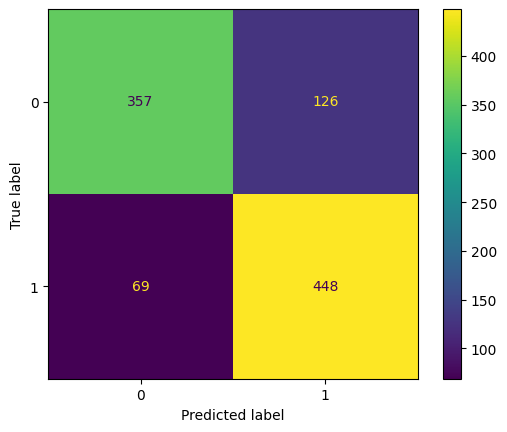

-----------------------------------------------------
DATASET: imdb_md
Accuracy score: 0.8042
Precision score: 0.7733851041298976


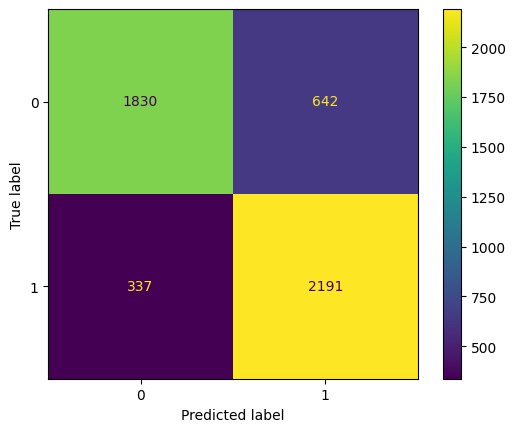

-----------------------------------------------------
DATASET: imdb_lg
Accuracy score: 0.8063684210526316
Precision score: 0.7732261116367076


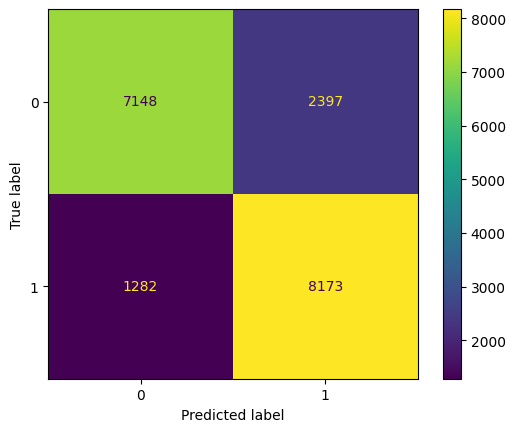

-----------------------------------------------------
DATASET: short_sm
Accuracy score: 0.75
Precision score: 0.7869589657110736


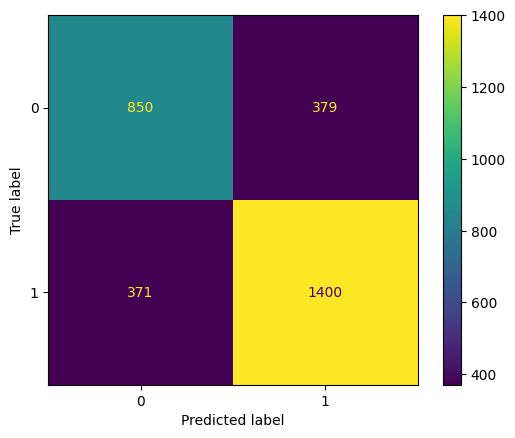

-----------------------------------------------------
DATASET: short_lg
Accuracy score: 0.7520634231103388
Precision score: 0.8048513587452125


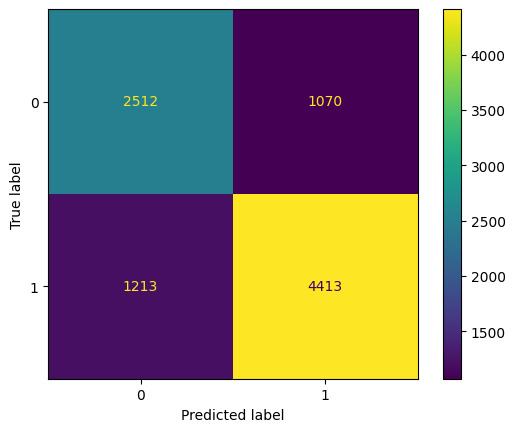

-----------------------------------------------------
DATASET: rotten_mix
Accuracy score: 0.7537
Precision score: 0.809607969151671


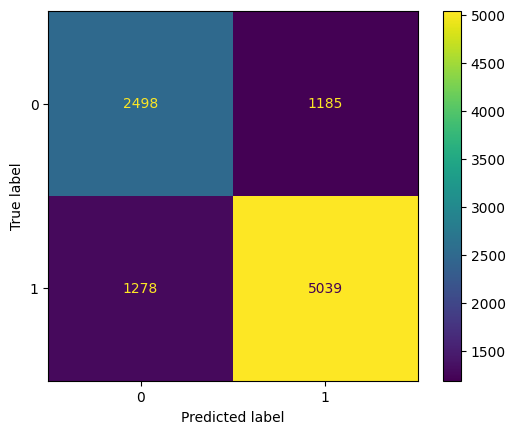

-----------------------------------------------------
DATASET: long (v2+imdb)
Accuracy score: 0.7161840816897468
Precision score: 0.6871401151631478


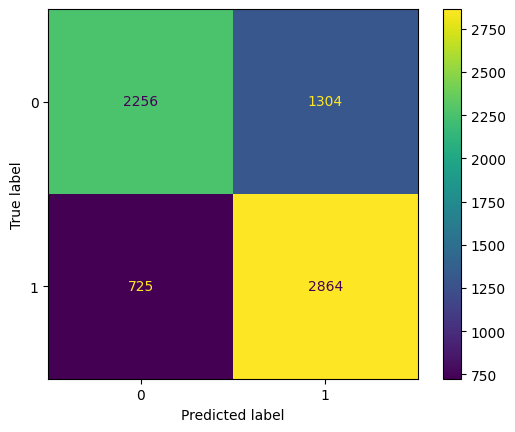

-----------------------------------------------------
DATASET: rest v1(more than 25 tokens)
Accuracy score: 0.7360793287566743
Precision score: 0.7137150466045273


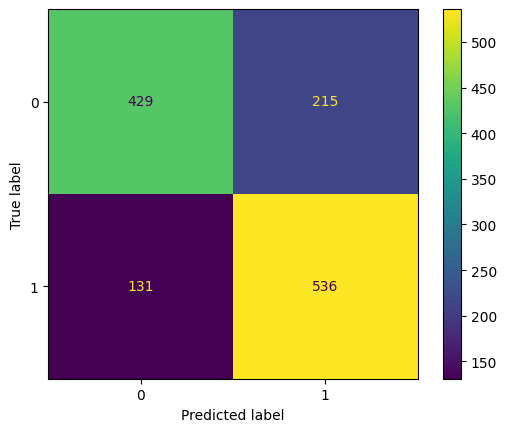

-----------------------------------------------------
DATASET: entire v2
Accuracy score: 0.681
Precision score: 0.6568457538994801


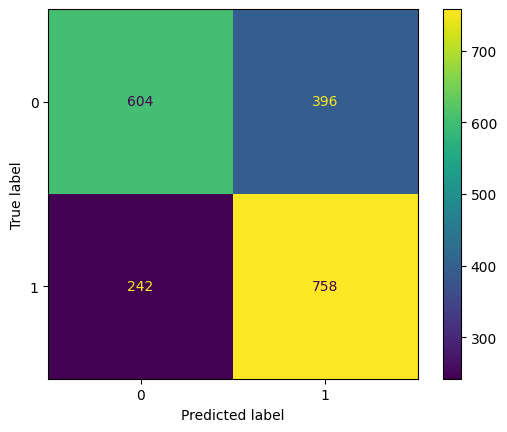

-----------------------------------------------------
DATASET: rotten_pos_only
Accuracy score: 0.805
Precision score: 1.0


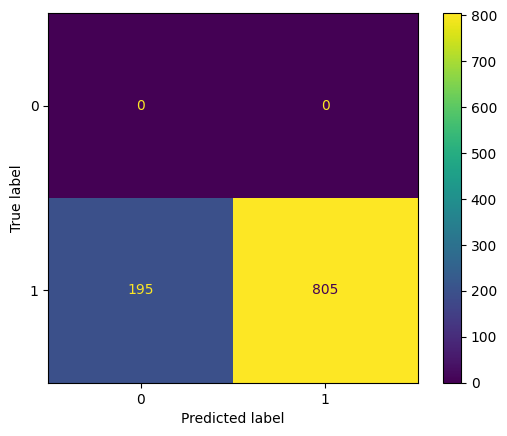

-----------------------------------------------------
DATASET: rotten_neg_only
Accuracy score: 0.674
Precision score: 0.0


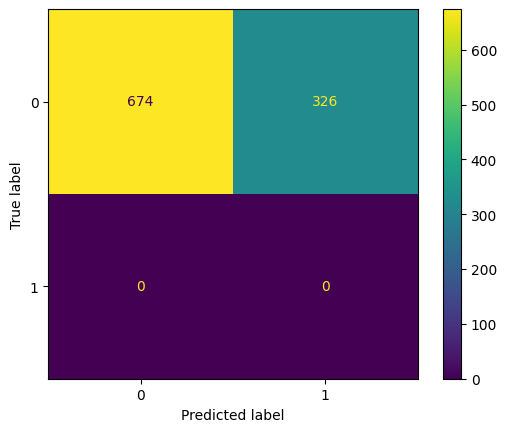

-----------------------------------------------------


In [247]:
results_dict = {}

for (X_test, y_test, name) in encoded_test_sets:
    acc, precision = test_loop(X_test, y_test, set_name=name, model=model)
    acc_key = f"{name}_acc"
    prec_key = f"{name}_prec"
    
    results_dict[acc_key] = acc
    results_dict[prec_key] = precision   